Customer churn is a critical metric for retailers. Understanding churn is not only about recognizing lost sales. It's a test for understanding customer satisfaction and loyalty.


In this example, we'll look at how to measure your churn and its impact on your business.


In this example we'll look at how to measure your churn and it's impact on your business.

### Setup

In [4]:
from datetime import datetime

import matplotlib.pyplot as plt
import pandas as pd

from pyretailscience import customer
from pyretailscience.data.simulation import Simulation

In [5]:
from pyretailscience.data.simulation import config_schema
import strictyaml as yaml

config_file = "../../data/default_data_config.yaml"
with open(config_file, "r") as f:
        config = yaml.load(f.read(), config_schema).data

config["transactions"]["start_date"] = datetime(year=2023, month=1, day=1)
sim = Simulation(seed=42, config=config)
sim.run()
df = pd.DataFrame(sim.transactions)

Simulating days: 100%|██████████| 364/364 [00:40<00:00,  8.91it/s]


Some details about the data

In [6]:
print(f"Number of unique customers: {df['customer_id'].nunique()}")
print(f"Number of unique transactions: {df['transaction_id'].nunique()}")

Number of unique customers: 2500
Number of unique transactions: 17693


### Assess the current situation

#### Finding your churn window

All churn analysis starts with picking the churn period. This is the period after which you will consider the customer to have churned. Typically, businesses measure this as some days after the customer's last transaction.

> **Note:**
>
> Another way is to estimate when each customer will churn. This is instead of having a single fixed churn window. It is often called "time-to-event prediction" or "survival analysis." It is an advanced technique, but it can be hard to do. Challenges include collecting and managing data. The data must cover a long time to enable the analysis. The result is often to "censor" the data or, in other words, limit the data used in the model. Most examples we've seen involve "right censoring" the data. This means setting a cut-off window. For example, say any customer who "survives" the past 12 months is still active. This results in a situation where some have a long churn window, others a short one. This makes a more detailed but more complex churn window. You'll need to consider whether the added benefit is offset by your business case.

Let's start by identifying the typical number of days between customer purchases.


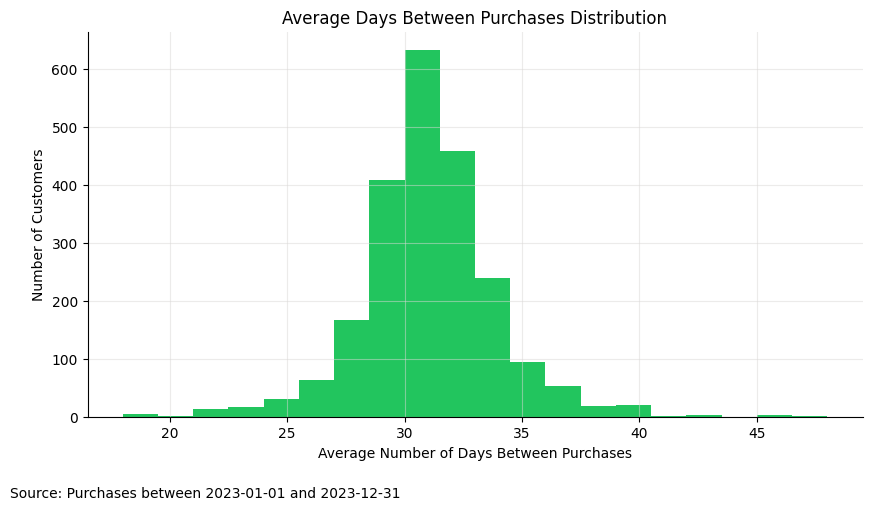

In [7]:
dbp = customer.DaysBetweenPurchases(df)
dbp.plot(
    figsize=(10, 5),
    bins=20,
    source_text="Source: Purchases between 2023-01-01 and 2023-12-31",
)
plt.show()

Here, we can see that customers seem to be on a roughly monthly shopping cycle. We can look at this data another way to help us set a churn window, by asking the question in a probabilistic way. Specifically,

**How many days will need to have passed such that 80% of customers would have purchased?**

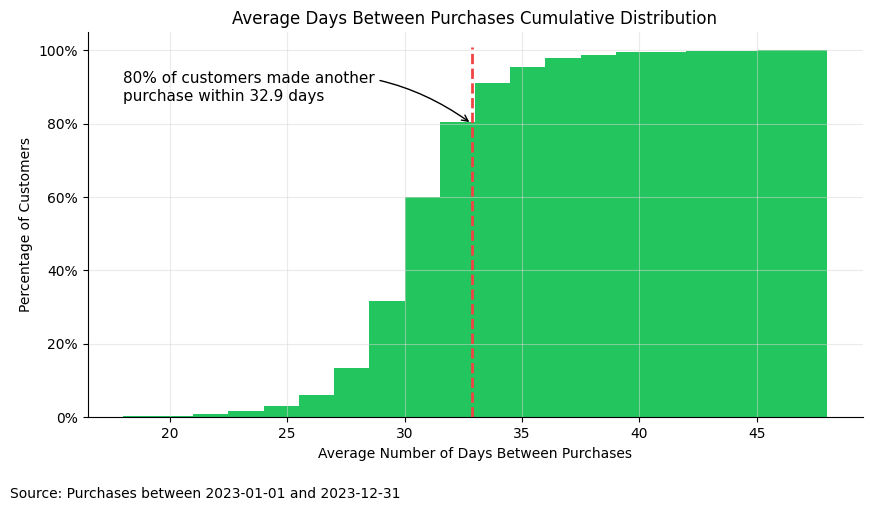

In [8]:
ax = dbp.plot(
    figsize=(10, 5),
    bins=20,
    cumlative=True,
    draw_percentile_line=True,
    percentile_line=0.8,
    source_text="Source: Purchases between 2023-01-01 and 2023-12-31",
)

# Let's dress up the chart a bit of text and get rid of the legend
churn_period = dbp.purchases_percentile(0.8)
ax.annotate(
    f"80% of customers made another\npurchase within {churn_period:.1f} days",
    xy=(churn_period, 0.80),
    xytext=(dbp.purchase_dist_s.min(), 0.90),
    fontsize=11,
    ha="left",
    va="center",
    arrowprops=dict(facecolor="black", arrowstyle="->", connectionstyle="arc3,rad=-0.25"),
)
ax.legend().set_visible(False)
plt.show()

Ok so now you have your churn period. 80% of customers made a purchase within 33 days of their last purchase. As a result we'll assume that if a customer hasn't purchased within the last 33 days they have churned.

### Transaction vs Period Churn

Depending on your business, you may want to focus on period churn or transaction churn.

**Period churn**
Period, or time frame, churn is the most common way to speak about churn. You'll often hear phrases like monthly or quarterly churn.

The period is often selected based on customers' buying patterns. Eg, if you are a clothing company, you may expect customers to come each quarter with each new season. In this case, you would choose a 12-week churn period. Even so, we still recommend calculating your churn window to validate your assumptions.

**Transaction churn**
Transaction churn is the other way of looking at churn. In this case, you focus on how quickly customers churn after each transaction. You may have heard of phrases like one-and-done churn. This refers to the rate of churn after one transaction.

**When to consider one versus the other**

Transaction churn is most interesting when you are focusing on moving new customers from an acquired state in the customer lifecycle into stable (or regular) buying pattern state. 

A period churn rate measurement is more applicable if you are mostly concerned with keeping customers in a stable buying pattern.

**Shouldn't I use both?**

From a practical perspective, this is an advanced retention strategy. It should only be combined with a lifecycle segmentation and when you are having trouble moving customers into a stable purchasing state. You can observe this if you see a steady decline in churn as the number of transactions increases.

Let's start by looking at transaction churn

### Transaction churn

Ideally, we would have all of a company's transaction data. In that case, we can confidently know a customer's first transaction and count from that time.

If you don't have all the transaction data, try and get the date of each customer's first transaction. Exclude those customers whose first transaction is outside your time window.

**You have all the transaction data**

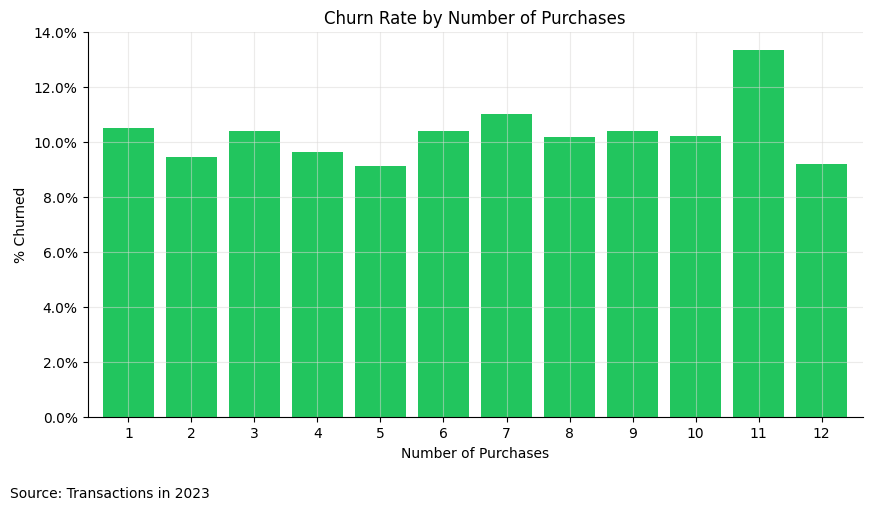

In [10]:
tc = customer.TransactionChurn(df, churn_period=churn_period)
tc.plot(
    figsize=(10, 5),
    source_text="Source: Transactions in 2023",
)
plt.show()

Here we can see a high churn rate. It's about 10% after each transaction. The simulated data has a churn rate of 10% configured after each transaction, so this is as expected.

Now let's look at this from a slightly different perspective. What percent of customers will have churned after each transaction.

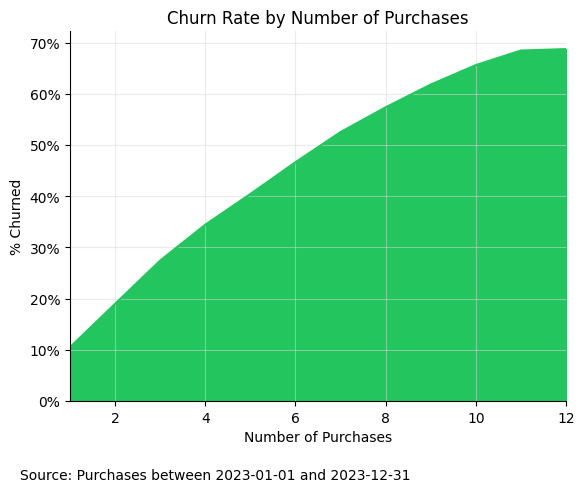

In [12]:
tc.plot(
    cumlative=True,
    figsize=(10, 5),
    source_text="Source: Purchases between 2023-01-01 and 2023-12-31",
)
plt.show()

## Coming soon

* Transaction churn with incomplete data
* Period churn
* Measuring the cost of customer churn to the business
* Cohort analysis of customer churn
* ... and more
